Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Alejandro Puerto"
COLLABORATORS = "Gonzalo Peraza"

---

# Anomaly and Outlier Detection

_Note: Most text is excerpted verbatim from references listed at the end. Some exercises are adapted from the course from Andrew NG on Coursera. This notebook is not intended for publication, it is a class reference material._

Anomaly detection is the process of identifying unexpected items or events in datasets, which differ from the norm. In contrast to standard classification tasks, anomaly detection is often applied on unlabeled data, taking only the internal structure of the dataset into account. Anomalies are often associated with particular interesting events or suspicious data records. Anomalies are known to have two important characteristics:

1. Anomalies are different from the norm with respect to their features and
2. They are rare in a dataset compared to normal instances.

Anomaly detection algorithms are now used in many application domains and often enhance traditional rule-based detection systems, for example:
- Intrusion detection
- Fraud detection
- Data Leakage Prevention

We can distinguish between three main types of anomaly detection: Supervised Anomaly Detection, Semi-supervised Anomaly Detection, and Unsupervised Anomaly Detection. Unsupervised Anomaly Detection is the most flexible setup which does not require any labels. Furthermore, there is also no distinction between a training and a test dataset. The idea is that an unsupervised anomaly detection algorithm scores the data solely based on intrinsic properties of the dataset. Typically, distances or densities are used to give an estimation what is normal and what is an outlier. 

 <figure>
  <img src="Figures/journal.pone.0152173.g001.PNG" alt="Types" style="width: 700px">
  <figcaption>Fig 1. Different anomaly detection modes depending on the availability of labels in the dataset.
(a) Supervised anomaly detection uses a fully labeled dataset for training. (b) Semi-supervised anomaly detection uses an anomaly-free training dataset. Afterwards, deviations in the test data from that normal model are used to detect anomalies. (c) Unsupervised anomaly detection algorithms use only intrinsic information of the data in order to detect instances deviating from the majority of the data.
https://doi.org/10.1371/journal.pone.0152173.g001
    </figcaption>
</figure> 

The output of an unsupervised anomaly detection algorithm is often a score. Here, we also use scores and rank the results such that the ranking can be used for performance evaluation. Of course, a ranking can be converted into a label using an appropriate threshold.

## Types of anomalies

 <figure>
  <img src="Figures/journal.pone.0152173.g002.PNG" alt="Types of anomaly" style="width: 700px">
  <figcaption>Fig 2. A simple two-dimensional example.
It illustrates global anomalies (x1, x2), a local anomaly x3 and a micro-cluster c3.
https://doi.org/10.1371/journal.pone.0152173.g002
    </figcaption>
</figure> 

In Fig 2 two anomalies can be easily identified by eye: x1 and x2 are very different from the dense areas with respect to their attributes and are therefore called global anomalies. When looking at the dataset globally, x3 can be seen as a normal record since it is not too far away from the cluster c2. However, when we focus only on the cluster c2 and compare it with x3 while neglecting all the other instances, it can be seen as an anomaly. Therefore, x3 is called a local anomaly, since it is only anomalous when compared with its close-by neighborhood. It depends on the application, whether local anomalies are of interest or not. Another interesting question is whether the instances of the cluster c3 should be seen as three anomalies or as a (small) regular cluster. These phenomena is called micro cluster and anomaly detection algorithms should assign scores to its members larger than the normal instances, but smaller values than the obvious anomalies. This simple example already illustrates that anomalies are not always obvious and a score is much more useful than a binary label assignment.

To this end, an anomaly is always referred to a single instance in a dataset only occurring rarely. In reality, this is often not true. For example, in intrusion detection, anomalies are often referred to many (suspicious) access patterns, which may be observed at a larger amount as the normal accesses. In this case, an unsupervised anomaly detection algorithm directly applied on the raw data will fail. The task of detecting single anomalous instances in a larger dataset (as introduced so far) is called point anomaly detection. Nearly all available unsupervised anomaly detection algorithms today are from this type. If an anomalous situation is represented as a set of many instances, this is called a collective anomaly. Each of these instances is not necessarily a point anomaly, but only a specific combination thereof defines the anomaly. The previous given example of occurring multiple specific access patterns in intrusion detection is such a collective anomaly. A third kind are contextual anomalies, which describe the effect that a point can be seen as normal, but when a given context is taken into account, the point turns out to be an anomaly. The most commonly occurring context is time. As an example, suppose we measure temperature in a range of 0°to 35°C during the year. Thus, a temperature of 26°C seems pretty normal, but when we take the context time into account (e.g. the month), such a high temperature of 26°C during winter would definitively be considered as an anomaly.

 <figure>
  <img src="Figures/journal.pone.0152173.g003.PNG" alt="Types of anomaly" style="width: 1000px">
  <figcaption>Fig 3. A taxonomy of unsupervised anomaly detection algorithms comprising of four main groups.
Note that CMGOS can be categorized in two groups: It is a clustering-based algorithm as well as estimating a subspace of each cluster.
    </figcaption>
</figure> 

In [2]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## Statistical Method: Gaussian model (Mahalanobis distance)

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in the wine dataset. Among the 13 features we'll select 2 to keep the data two dimensional and explore how the algorithm works. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of wine types, but there might also be some examples of anomalous wines within this dataset, (whatever that means).

You will use a Gaussian model to detect anomalous examples in your dataset. On the 2D dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

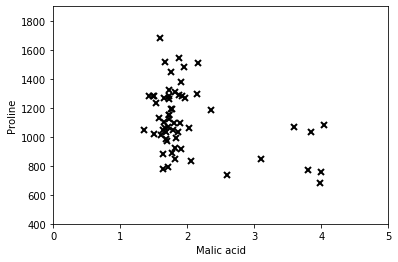

In [3]:
#  The following command loads the dataset.
from sklearn.datasets import load_wine

# Select the first class (59 elements), columns 'Malic acid' and 'Proline' (see DESCR)
X = load_wine()['data'][:59, [1,12]]

#  Visualize the example dataset
plt.plot(X[:,0], X[:,1], 'bx', mew=2, mec='k', ms=6)
plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

### Multivariate Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data's distribution. The Multivariate Gaussian distribution is given by
$$
p\left( x; \mu, \Sigma \right)  = \frac{1}{  \sqrt{  \left( 2\pi\right)^k  \left|\Sigma\right|  }}
\exp\left(-\frac{1}{2} \left(x - \mu \right)^T \Sigma^{-1}\left(x - \mu \right)\right)
$$

where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix.

### 1.2 Estimating parameters for a Gaussian 

You can estimate the parameters by using the following equations. To estimate the mean, you will use: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the covariance you will use:

$$ \Sigma = \frac{1}{n}\left(X - 1 \mu^T \right)^T\left(X - 1 \mu^T \right)$$

Your task is to complete the code in the function `estimateGaussian`. This function takes as input the data matrix `X` and should output an n-dimension vector `mu` that holds the mean for each of the $n$ features and the nxn covariance matrix `Sigma` that holds the variances of each of the features. 

In [4]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    Sigma : array_like
        The (n x n) covariance matrix.
    
    Instructions
    ------------
    Compute the mean of the data and the variances
    In particular, mu[i] should contain the mean of
    the data for the i-th feature and Sigma[i,j]
    should contain covariance between the i-th and 
    the j-th feature.
    """
    # Useful variables
    m, n = X.shape
    
    # You should return these values correctly
    mu = np.zeros(n)
    Sigma = np.zeros((n, n))

    # YOUR CODE HERE
    mu = np.mean(X, axis=0)
    Sigma = 1/n * (X-mu).T @ (X-mu)
    #raise NotImplementedError()
    
    return mu, Sigma

Once you have completed the code in `estimateGaussian`, the next cell will visualize the contours of the fitted Gaussian distribution. 

From your plot, you can see that most of the examples are in the region with the highest probability, while
the anomalous examples are in the regions with lower probabilities.

To do the visualization of the Gaussian fit, we first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

In [5]:
def multivariateGaussian(X, mu, Sigma):
    """
    Computes the probability density function of the multivariate gaussian distribution.

    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.

    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).

    Sigma : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.

    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    """
    k = mu.size

    # if sigma is given as a diagonal, compute the matrix
    if Sigma.ndim == 1:
        Sigma = np.diag(Sigma)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma) ** (-0.5)\
        * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(Sigma) * X, axis=1))
    return p

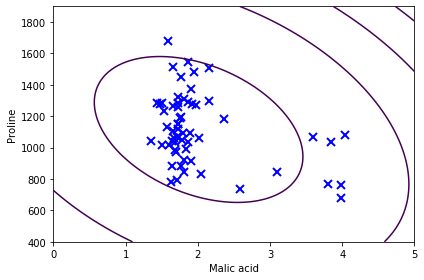

In [6]:
#  Estimate my and sigma2
mu, Sigma = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, Sigma)

#  Visualize the fit
X1, X2 = np.meshgrid(np.linspace(0, 5, 100), np.linspace(400, 1900, 100))
Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, Sigma)
Z = Z.reshape(X1.shape)

plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)

if np.all(abs(Z) != np.inf):
    plt.contour(X1, X2, Z, levels=np.geomspace(1e-10, 1, 100), zorder=100)
plt.xlabel('Malic acid');
plt.ylabel('Proline');
plt.tight_layout();

There is a problem with the previous estimation of our normal distribution. By inspecting the plot, it is clear that if outliers where removed the shape of the distribution should be an ellipse almost aligned with the y-axis. The problem is that the estimation of the covariance matrix is heavily influenced by the outliers. In principle, we would like to estimate the covariance using only the clean subset of the data.

One way to solve this problems is to use a robust estimator for the covariance matrix called the Minimum Covariance Determinant. The Minimum Covariance Determinant estimator is a robust, high-breakdown point (i.e. it can be used to estimate the covariance matrix of highly contaminated datasets, up to $\frac{n_\text{samples} - n_\text{features} - 1}{2}$ outliers) estimator of covariance. The idea is to find $\frac{n_\text{samples}+n_\text{features}+1}{2}$ observations whose empirical covariance has the smallest determinant, yielding a "pure" subset of observations from which to compute standards estimates of location and covariance.

In [7]:
from sklearn.covariance import MinCovDet

def estimateGaussianRobust(X):
    
    robust_cov = MinCovDet().fit(X)
    mu = robust_cov.location_
    Sigma = robust_cov.covariance_
    
    return mu, Sigma

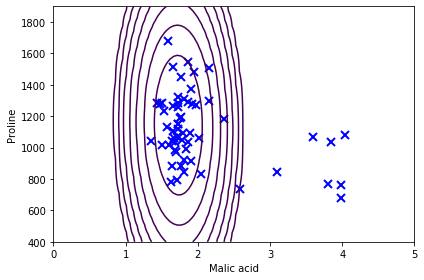

In [8]:
#  Estimate my and sigma2
mu, Sigma = estimateGaussianRobust(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, Sigma)

#  Visualize the fit
X1, X2 = np.meshgrid(np.linspace(0, 5, 100), np.linspace(400, 1900, 100))
Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, Sigma)
Z = Z.reshape(X1.shape)

plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)

if np.all(abs(Z) != np.inf):
    plt.contour(X1, X2, Z, levels=np.geomspace(1e-10, 1, 10), zorder=100)
plt.xlabel('Malic acid');
plt.ylabel('Proline');
plt.tight_layout();

### Choosing the threshold

Now, the outliers are identified as the points having the lowest probability according to the fitted model. This probabilities can serve as the scores of our method. Because of the "squashing" effect of the exponential, its much clearer to use the Mahalanobis distance, which is just the exponent of the multivariate gaussian.
$$
MD(x) = \sqrt{\left(x - \mu \right)^T\Sigma^{-1}\left(x - \mu\right)}
$$

In [9]:
def MD(X):
    mu, Sigma = estimateGaussianRobust(X)

    # YOUR CODE HERE
    MD = np.sqrt(np.sum((X - mu) @ np.linalg.inv(Sigma) * (X - mu), axis=1))
    #raise NotImplementedError()
    
    return MD

Top outliers:  [43 39 45 21 41 46 19  4]


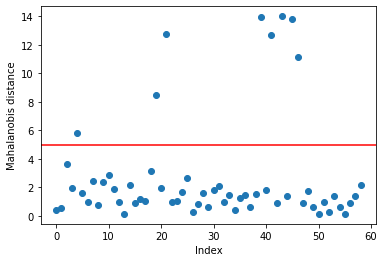

In [10]:
# Calculate the MD for each point, the plot the scores to identify possible outliers.

scores = MD(X)
threshold = 5

plt.axhline(threshold, color='red')
plt.plot(scores, 'o')
plt.xlabel('Index')
plt.ylabel('Mahalanobis distance')

n_outliers = (scores > threshold).sum()
top_outliers = np.argsort(scores)[::-1][:n_outliers]
print('Top outliers: ', top_outliers)

## KNN

First, for every record in the dataset, the k-nearest-neighbors have to be found. Then, an anomaly score is computed using these neighbors, whereas two possibilities have been proposed: Either the distance to the kth-nearest-neighbor is used (a single one) or the average distance to all of the k-nearest-neighbors is computed. In the following, we refer to the first method as kth-NN and the latter as k-NN. In practical applications, the k-NN method is often preferred. However, the absolute value of the score depends very much on the dataset itself, the number of dimensions, and on normalization. As a result, it is in practice not easy to select an appropriate threshold, if required.

Our KNN algorithm will use a brute force approach to calculate the nearest neighbors. This implies the calculation of $N^2$ pairwise distances among all observations (rows) of the data matrix. More efficient approaches for large datasets employ KDTrees or BallTrees (https://scikit-learn.org/stable/modules/neighbors.html). Euclidian distance is often used, but other metrics can be employed as well. The distance matrix is an $N\times N$ matrix defined as:
$$
D = \begin{pmatrix}
d(x_1,x_1) & d(x_1,x_2) & \dots & d(x_1,x_n)\\
d(x_2,x_1) & d(x_2,x_2) & \dots & d(x_2,x_n)\\
\vdots & \vdots & \ddots & \vdots\\
d(x_n,x_1) & d(x_n,x_2) & \dots & d(x_n,x_n)
\end{pmatrix}
$$

There exists an efficient way to calculate this matrix using Numpy broadcasting. To do this, we need to transform our original data matrix $X$ into new 3D arrays that repeat X along a given dimension. The purpose is to obtain 3D array with all elements of the form $x_{ik} - x_{jk}$ indexed as $ijk$. If you are unfamiliar with broadcasting operations, you may wish to implement this as a nested for loop, at the cost of being slower.

In [11]:
def distance_matrix(X):
    """Returns the distance matrix from a data matrix X. """
    
    # YOUR CODE HERE
    Xik = X[:, np.newaxis, :]
    Xjk = X[np.newaxis, :, :]
    D = np.sum((Xik - Xjk) ** 2, axis = -1)**0.5
    #raise NotImplementedError()
    
    return D

### K$^{th}$NN algorithm

For the  K$^{th}$NN algorithm we need to find the distance to the kth neighbor of each observation, then sort according to those scores. The larger the distance, the more likely a point is to be an outlier.

In [12]:
def scores_kthnn(X, k):
    """ Return the oulier scores given by the distance to the kth neighbor."""
    
    # Find the distance matrix
    # YOUR CODE HERE
    D = distance_matrix(X)
    #raise NotImplementedError()
    
    # Sort the distance matrix row by row.
    # YOUR CODE HERE
    D_sorted = np.sort(D, axis=1)
    #raise NotImplementedError()
    
    # Take the k column (excluding self distance)
    # YOUR CODE HERE
    scores = D_sorted[:,k+1]
    #raise NotImplementedError()
    
    return scores

### KNN algorithm
 For the KNN algorithm we need the average distance from the first k neighbors:

In [13]:
def scores_knn(X, k):
    """ Return the oulier scores given by the average distance to first k neighbors."""
    
    # Find the distance matrix
    # YOUR CODE HERE
    D = distance_matrix(X)
    #raise NotImplementedError()
    
    # Sort the distance matrix row by row.
    # YOUR CODE HERE
    D_sorted = np.sort(D, axis=1)
    #raise NotImplementedError()
    
    # Take the average up to the k column (excluding self distance)
    # YOUR CODE HERE
    scores = D_sorted[:,1:k+1]
    scores = np.average(scores, axis=1)
    #raise NotImplementedError()
    
    return scores

The choice of the parameter k is of course important for the results. If it is chosen too low, the density estimation for the records might be not reliable. On the other hand, if it is too large, density estimation may be too coarse. As a rule of thumb, k should be in the range 10 < k < 50.

Testing KNN in the wine dataset should output the following result:

![](Knn-outliers.png)

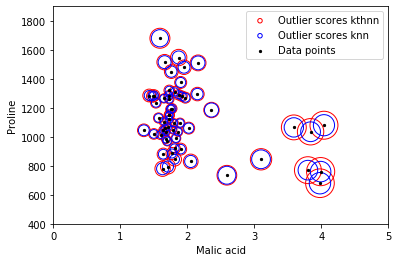

In [14]:
# Normalize the data matrix, this step is important
# since the scale of the two columns differs significantly
from sklearn import preprocessing

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)

k = 10
kthnn_scores = scores_kthnn(X_scaled, k)
knn_scores = scores_knn(X_scaled, k)

plt.scatter(X[:,0], X[:,1], s=1000*kthnn_scores, edgecolors='r',
            facecolors='none', label='Outlier scores kthnn')
plt.scatter(X[:,0], X[:,1], s=1000*knn_scores, edgecolors='b',
            facecolors='none', label='Outlier scores knn')
plt.scatter(X[:,0], X[:,1], s=5, color='k', label='Data points')
legend = plt.legend()
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [20]

plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

## LOF

The local outlier factor is the most well-known local anomaly detection algorithm and also introduced the idea of local anomalies first.
To calculate the LOF score, three steps have to be computed:
1. The k-nearest-neighbors have to be found for each record x. In case of distance tie of the kth neighbor, more than k neighbors are used.
2. Using these k-nearest-neighbors $N_k$, the local density for a record is estimated by computing the local reachability density (LRD):
$$
LRD_k(x) = 1/\left(  \frac{\sum\limits_{o\in N_k(x)} d_k(x,o)}{\left|N_k(x)\right|} \right)
$$
whereas dk(·) is the reachability distance. Except for some very rare situations in highly dense clusters, this is the Euclidean distance.
3. Finally, the LOF score is computed by comparing the LRD of a record with the LRDs of its k neighbors:
$$
LOF(x) = \frac{\sum\limits_{o\in N_k(x)}\frac{LRD_k(o)}{LRD_k(x)}}{\left|N_k(x)\right|}
$$

The LOF score is thus basically a ratio of local densities. This results in the nice property of LOF, that normal instances, which densities are as big as the densities of their neighbors, get a score of about 1.0. Anomalies, which have a low local density, will result in larger scores. At this point it is also clear why this algorithm is local: It only relies on its direct neighborhood and the score is a ratio mainly based on the k neighbors only. Of course, global anomalies can also be detected since they also have a low LRD when comparing with their neighbors. It is important to note that in anomaly detection tasks, where local anomalies are not of interest, this algorithm will generate a lot of false alarms.

The reachability distance is defined as:
$$
d_k(x, o) = \max\left( k-distance(o), d(x,o)  \right)
$$

In words, the reachability distance of an object $x$ from $o$ is the true distance of the two objects, but at least the k-distance of $o$. Objects that belong to the k nearest neighbors of $o$ (the "core" of $o$) are considered to be equally distant, i.e., equally reachable from $o$. The reason for this distance is to get more stable results. Note that this is not a distance in the mathematical definition, since it is not symmetric.

In [15]:
def lof(X, k):
    # Find the distance matrix
    # YOUR CODE HERE
    D = distance_matrix(X)
    #raise NotImplementedError()
    
    # Sort the distance matrix row by row to obtain the k neighborhood of each row.
    # YOUR CODE HERE
    D_sorted = np.sort(D, axis=1)
    Nk_distance = D_sorted[:,1:k+1]
    #raise NotImplementedError()
        
    # Store the k-distance of each observation
    # YOUR CODE HERE
    k_distance = Nk_distance[:,-1] #Max to min
    #raise NotImplementedError()
    
    # Also store the indices of the neighbors to find the k-distance of each point o.
    # YOUR CODE HERE
    D_sorted_index = np.argsort(D)
    Nk_index = D_sorted_index[:,1:k+1]
    #raise NotImplementedError()
    #print(Nk_index.shape)
       
    # Find the reachability distances of each neighborhood
    # Note: Numpy fancy indexing is your friend
    # YOUR CODE HERE
    reach_distance = np.zeros((len(X), k))
    for i, x in enumerate(X):
        for j, o in enumerate(Nk_index[i]):
            reach_distance[i,j] = max(D[i,o],k_distance[o])
            
    #reach_distance = (np.maximum(Nk_distance, k_distance[Nk_index]))
    #raise NotImplementedError()
    #print(r_dist)
    #print(reach_distance)
    
    # Find LDR for each observation
    # YOUR CODE HERE
    lrd = 1/(np.sum(reach_distance, axis=1) / k)
    #raise NotImplementedError()
    #print(lrd.shape)
    
    #Find LOF scores
    # YOUR CODE HERE
    scores = (np.sum(lrd[Nk_index], axis=1) / lrd) / k
    #raise NotImplementedError()
    #print(scores.shape)
    
    return scores

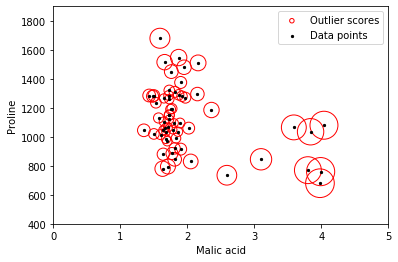

In [16]:
# Normalize the data matrix, this step is important
# since the scale of the two columns differs significantly
from sklearn import preprocessing

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)

k = 10
lof_scores = scores_kthnn(X_scaled, k)

plt.scatter(X[:,0], X[:,1], s=1000*lof_scores, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.scatter(X[:,0], X[:,1], s=5, color='k', label='Data points')
legend = plt.legend()
legend.legendHandles[0]._sizes = [20]

plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

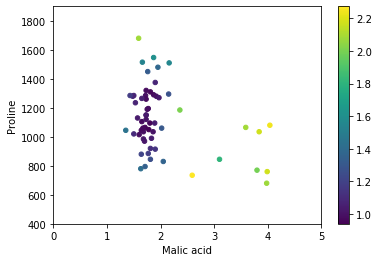

In [17]:
# Normalize the data matrix, this step is important
# since the scale of the two columns differs significantly
from sklearn import preprocessing

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)

k = 10
lof_scores = lof(X_scaled, k)

plt.scatter(X[:,0], X[:,1], s=20, c=lof_scores)
plt.colorbar()

plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

## ABOD

The main idea behind ABOD is that if $x$ is an outlier, the variance of angles between pairs of the remaining objects becomes small:

![](Figures/abod.png)

For a point within a cluster, the angles between
difference vectors to pairs of other points differ widely. The
variance of the angles will become smaller for points at the
border of a cluster. However, even here the variance is still
relatively high compared to the variance of angles for real
outliers. Here, the angles to most pairs of points will be
small since most points are clustered in some directions.

As a result of these considerations, an angle-based outlier factor (ABOF) can describe the
divergence in directions of objects relatively to one another.
If the spectrum of observed angles for a point is broad, the
point will be surrounded by other points in all possible directions meaning the point is positioned inside a cluster. If
the spectrum of observed angles for a point is rather small,
other points will be positioned only in certain directions.
This means, the point is positioned outside of some sets of
points that are grouped together. Thus, rather small angles
for a point that are rather similar to one another imply
that such point is an outlier.

ABOD has been proposed as able to perform outlier detection more reliably in high dimensional data sets than distance based methods.

A problem of the basic approach ABOD is obvious: since
for each point all pairs of points must be considered, the
time-complexity is in O($n^3$), the original ABOD paper proposes two approximations to address this problem: FastABOD and LB-ABOD. These will not be discussed here.


### The Angled Based Outlier Factor (ABOF)

As an approach to assign the ABOF value to any object
in the database $\mathcal{D}$, we compute the scalar product of the
difference vectors of any triple of points (i.e. a query point $\vec{A} \in \mathcal{D}$
and all pairs $(\vec{B},\vec{C})$ of all remaining points in $\mathcal{D} \backslash \{\vec{A}\})$
normalized by the quadratic product of the length of
the difference vectors, i.e. the angle is weighted less if the
corresponding points are far from the query point. By this
weighting factor, the distance influences the value after all,
but only to a minor part. Nevertheless, this weighting of
the variance is important since the angle to a pair of points
varies naturally stronger for a bigger distance. The variance
of this value over all pairs for the query point $\vec{A}$
constitutes the angle-based outlier factor (ABOF) of $\vec{A}$.



$$
ABOF(\vec{A}) = VAR_{\vec{B},\vec{C}\in\mathcal{D}} \left( \frac{\left<\overline{AB}, \overline{AC}\right>}
{\left\Vert \overline{AB}  \right\Vert^2 \cdot \left\Vert \overline{AC}  \right\Vert^2} \right)\\
= \frac
{\sum_B\sum_C\left(
\frac{1}{\left\Vert \overline{AB}  \right\Vert \cdot \left\Vert \overline{AC}  \right\Vert}
\frac{\left<\overline{AB}, \overline{AC}\right>}{\left\Vert \overline{AB}  \right\Vert^2 \cdot \left\Vert \overline{AC}  \right\Vert^2} 
\right)^2}
{\sum_B\sum_C\frac{1}{\left\Vert \overline{AB}  \right\Vert \cdot \left\Vert \overline{AC}  \right\Vert}} - 
\left(\frac
{\sum_B\sum_C
\frac{1}{\left\Vert \overline{AB}  \right\Vert \cdot \left\Vert \overline{AC}  \right\Vert}
\frac{\left<\overline{AB}, \overline{AC}\right>}{\left\Vert \overline{AB}  \right\Vert^2 \cdot \left\Vert \overline{AC}  \right\Vert^2} 
}
{\sum_B\sum_C\frac{1}{\left\Vert \overline{AB}  \right\Vert \cdot \left\Vert \overline{AC}  \right\Vert}}\right)^2
$$

__NOTE__: This way of weighting the cosine similar is weird in my opinion. In fact, the pyod package implements ABOD without these weights. I'm not sure which way is the correct one, or even is one can say that either can be wrong, since the constructions of the algorithm is not based in any formalism. I have yet yo find a discussion about the issue.

In [18]:
def abof(a, X):
    """ Returns abof score for X[a] """
    
    m = len(X)
    # Variablea to store the first and second terms of the varince
    var1 = 0
    var2 = 0
    # variable to store the normalization constant (sum of weights)
    norm_c = 0
    
    # Loop over all pairs of points
    for b in range(m):
        if a == b:
            continue
        for c in range(b+1, m):
            if a == c:
                continue
            # YOUR CODE HERE
            ab = X[b] - X[a]
            ac = X[c] - X[a]
            ab_ac_product = np.linalg.norm(ab) * np.linalg.norm(ac)
            ab_ac_scalar = np.dot(ab, ac)
            if ab_ac_product == 0:
                continue
            var1 = var1 + ((1/ab_ac_product) * (ab_ac_scalar/(ab_ac_product**2)))**2
            var2 = var2 + (1/ab_ac_product) * (ab_ac_scalar/(ab_ac_product**2))
            norm_c = norm_c + (1/ab_ac_product)
            
            #raise NotImplementedError()
            
    var = var1/norm_c - (var2/norm_c)**2
    
    return var            

In [19]:
def abod(X):
    """ Retrun abof scores for X """
    
    scores = []
    for a in range(len(X)):
        scores.append(abof(a, X))

    return np.array(scores)

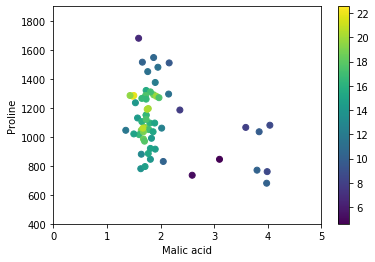

In [20]:
# Normalize the data matrix, this step is important
# since the scale of the two columns differs significantly
from sklearn import preprocessing

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)

k = 10
abod_scores = abod(X_scaled)

plt.scatter(X[:,0], X[:,1], c=np.log(abod_scores))
plt.colorbar()

plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

## iForest

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The Isolation Forest algorithm 'isolates' observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

An example of random partitioning in a 2D dataset of normally distributed points is given below for a non-anomalous point:

![](Figures/Isolating_a_Non-Anomalous_Point.png)

Another example for a point that's more likely to be an anomaly is now shown:

![](Figures/Isolating_an_Anomalous_Point.png)

It is apparent from the pictures how anomalies require fewer random partitions to be isolated, compared to normal points. 

From a mathematical point of view, recursive partitioning can be represented by a tree structure named Isolation Tree, while the number of partitions required to isolate a point can be interpreted as the length of the path, within the tree, to reach a terminating node starting from the root. 

More formally, let $X = \{ x_1, \ldots,  x_n \}$ be a set of d-dimensional points and $X' \subset X$ a subset of $X$. An Isolation Tree (iTree) is defined as a data structure with the following properties: 

1. for each node $T$ in the Tree, $T$ is either an external-node with no child, or an internal-node with one "test" and exactly two daughter nodes ($T_l$, $T_r$)
2. a test at node $T$ consists of an attribute $q$ and a split value $p$ such that the test $q < p$ determines the traversal of a data point to either $T_l$ or $T_r$.

In order to build an iTree, the algorithm recursively divides $X'$ by randomly selecting an attribute $q$ and a split value $p$, until either (i) the node has only one instance or (ii) all data at the node have the same values. 

When the iTree is fully grown, each point in $X$ is isolated at one of the external nodes. Intuitively, the anomalous points are those (easier to isolate, hence) with the smaller path length in the tree, where the path length $h(x_i)$ of point $x_{i}\in X$ is defined as the number of edges $x_i$ traverses from the root node to get to an external node. 

## References

- A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152173)
- https://scikit-learn.org/stable/modules/outlier_detection.html
- https://pyod.readthedocs.io/en/latest/
- https://github.com/yzhao062/anomaly-detection-resources
- https://arxiv.org/abs/1709.07045
- https://scikit-learn.org/stable/modules/neighbors.html
- https://en.wikipedia.org/wiki/Local_outlier_factor
- Angle-Based Outlier Detection in High-dimensional Data, Kriegel et.al.
- https://en.wikipedia.org/wiki/Isolation_forest
- Isolation Forest, Liu and Zhou